Biagio Buono - 5206214 <br>
Leonardo Puricelli - 5214494

# **Deep Learning Project**

In this paper we apply the model defined in the first notebook (*1_Landscape.ipynb*) to the Plant Disease Recognition dataset, available at the following link: https://www.kaggle.com/datasets/rashikrahmanpritom/plant-disease-recognition-dataset/download?datasetVersionNumber=1.

In [ ]:
%%capture
pip install d2l==1.0.0a1.post0

In [ ]:
%%capture

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import shutil
import random
from PIL import Image
import torchvision
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch.utils.data import DataLoader
from d2l import torch as d2l
import torch
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


# Plant Disease Recognition Dataset

The Plant Disease Recognition dataset is retrieved from Kaggle (https://www.kaggle.com/datasets/rashikrahmanpritom/plant-disease-recognition-dataset) and contains 1532 RGB images divided into Train, Test and Validation sets. The images are labeled as *Healthy*, *Rust* and *Powdery* to describe the condition of the plants. <br>
Very briefly, each category means the following:

- **Rust:** these are plants diseases caused by Pucciniales fungi, which cause severe deformities to the plants, such as yellow, orange or brown spots called pustules
- **Powdery:** powdery mildews are caused by Erysphales fungi, posing a threat to agriculture and horticulture by reducing crop yields
- **Healthy**: naturally, these are the plants that are free from diseases.

The development of a model capable of discerning among these three states of plants could benefit some activities, such as gardening, allowing to quickly figure out if a plant needs a treatment or not.

## Load the dataset

We unzip the file containing the dataset in our environment and set up the directories for each category in all the sets.

In [ ]:
%%capture
!unzip '/content/drive/MyDrive/plant_zippato.zip'

In [ ]:
train_directories = ['/content/Train/Train/Healthy',
                     '/content/Train/Train/Powdery',
                     '/content/Train/Train/Rust'
]

valid_directories = ['/content/Validation/Validation/Healthy',
                     '/content/Validation/Validation/Powdery',
                     '/content/Validation/Validation/Rust'
]

test_directories = ['/content/Test/Test/Healthy',
                    '/content/Test/Test/Powdery',
                    '/content/Test/Test/Rust'
]

Given the limited size of the validation set with only 20 images, we have chosen to allocate 10% of the training set images to enrich the diversity of the validation set.

In [ ]:
from sklearn.model_selection import train_test_split

validation_split = 0.1

for train_dir, valid_dir in zip(train_directories, valid_directories):
    files = os.listdir(train_dir)

    train_files, valid_files = train_test_split(files, test_size=validation_split, random_state=22)
    os.makedirs(valid_dir, exist_ok=True)

    for file in valid_files:
        src_path = os.path.join(train_dir, file)
        dest_path = os.path.join(valid_dir, file)
        shutil.move(src_path, dest_path)

        print(f"Moved: {file} from {train_dir} to {valid_dir}")

Moved: 87c2350afc10cbf7.jpg from /content/Train/Train/Healthy to /content/Validation/Validation/Healthy
Moved: 98a3667e4a19b476.jpg from /content/Train/Train/Healthy to /content/Validation/Validation/Healthy
Moved: 80abc9d697ec22b6.jpg from /content/Train/Train/Healthy to /content/Validation/Validation/Healthy
Moved: 85c5705c1f5abab8.jpg from /content/Train/Train/Healthy to /content/Validation/Validation/Healthy
Moved: 84b0d76a22257b6f.jpg from /content/Train/Train/Healthy to /content/Validation/Validation/Healthy
Moved: 80dcc12cc917ef5d.jpg from /content/Train/Train/Healthy to /content/Validation/Validation/Healthy
Moved: 84a507f705587f78.jpg from /content/Train/Train/Healthy to /content/Validation/Validation/Healthy
Moved: 839b918b7ced00fc.jpg from /content/Train/Train/Healthy to /content/Validation/Validation/Healthy
Moved: 96a6d2e993318b47.jpg from /content/Train/Train/Healthy to /content/Validation/Validation/Healthy
Moved: 852b3dcb856652d5.jpg from /content/Train/Train/Healthy to

Check for the number of images in each class:

In [ ]:
print('Frequency of images for each training category')
print()
for directory_path in train_directories:

    category_name = os.path.basename(directory_path)
    images_count = len(os.listdir(directory_path))
    print(f"Category: {category_name:<10}  - Number of images: {images_count}")

Frequency of images for each training category

Category: Healthy     - Number of images: 412
Category: Powdery     - Number of images: 387
Category: Rust        - Number of images: 390


In [ ]:
print('Frequency of images for each validation category')
print()
for directory_path in valid_directories:

    category_name = os.path.basename(directory_path)
    images_count = len(os.listdir(directory_path))
    print(f"Category: {category_name:<10} - Number of images: {images_count}")

Frequency of images for each validation category

Category: Healthy    - Number of images: 66
Category: Powdery    - Number of images: 63
Category: Rust       - Number of images: 64


In [ ]:
print('Frequency of images for each test category')
print()
for directory_path in test_directories:

    category_name = os.path.basename(directory_path)
    images_count = len(os.listdir(directory_path))

    print(f"Category: {category_name:<10} - Number of images: {images_count}")

Frequency of images for each test category

Category: Healthy    - Number of images: 50
Category: Powdery    - Number of images: 50
Category: Rust       - Number of images: 50


## Exploratory analysis

To have a first sight of the dataset, we define the following function to display a random image from each category within each set.

In [ ]:
def display_random_images(categories, dataset_title):
    rows, cols = 1, len(categories)
    fig, axs = plt.subplots(rows, cols, figsize=(10, 2))

    for idx,category in enumerate(categories):
        image_files = os.listdir(category)

        random_image_file = random.choice(image_files)
        image_path = os.path.join(category, random_image_file)

        img = mpimg.imread(image_path)
        axs[idx].imshow(img)
        axs[idx].axis('off')
        axs[idx].set_title(categories_list[idx])

    plt.suptitle(dataset_title, fontsize=16)
    plt.subplots_adjust(top=0.7, hspace=0.5)

    plt.show()

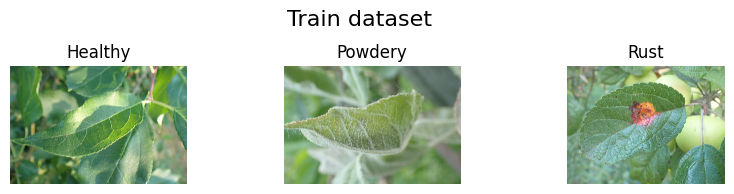

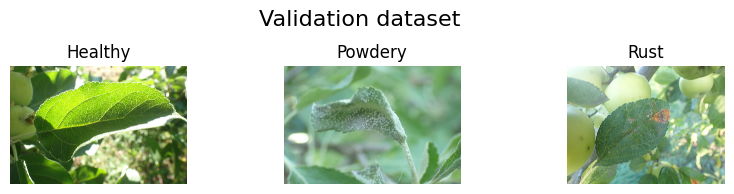

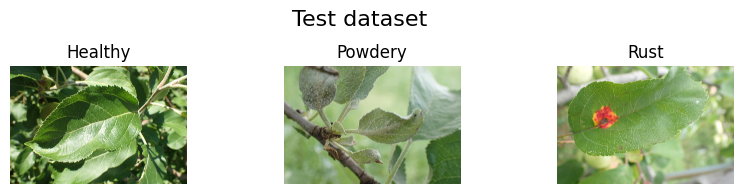

In [ ]:
categories_list = ['Healthy','Powdery','Rust']

display_random_images(train_directories, 'Train dataset')
display_random_images(valid_directories, 'Validation dataset')
display_random_images(test_directories, 'Test dataset')

Looking at the pictures above, it's possible to notice how, for some images, it may not be easy to distinguish the class membership, especially for **Healthy** and **Powdery**. For this reason, we might expect the model to face some difficulties in accurately predict them.

The following functions are defined to illustrate the frequency distribution of categories for each of the three sets.

In [ ]:
def plot_category_frequencies(categories, train_directories, valid_directories, test_directories):
    train_frequencies = []
    validation_frequencies = []
    test_frequencies = []

    for category in categories:
        train_count = len(os.listdir(train_directories[categories.index(category)]))
        validation_count = len(os.listdir(valid_directories[categories.index(category)]))
        test_count = len(os.listdir(test_directories[categories.index(category)]))

        train_frequencies.append(train_count)
        validation_frequencies.append(validation_count)
        test_frequencies.append(test_count)

    return train_frequencies, validation_frequencies, test_frequencies

def plot_training_validation_test_category_frequencies(categories, train_directories, validation_directories, test_directories):
    train_frequencies, validation_frequencies, test_frequencies = plot_category_frequencies(categories, train_directories, validation_directories, test_directories)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    bar_width = 0.6
    index = range(len(categories))
    colors = ['forestgreen', 'darkgray', 'sienna']

    bars_train = axs[0].bar(index, train_frequencies, bar_width, label='Training',color = colors)
    bars_valid = axs[1].bar(index, validation_frequencies, bar_width, label='Validation',color = colors)
    bars_test  = axs[2].bar(index, test_frequencies, bar_width, label='Test',color = colors)

    axs[0].set_xlabel('Categories')
    axs[0].set_ylabel('Number of Images')
    axs[0].set_title('Frequencies of Categories in Training Dataset')
    axs[0].set_xticks(index)
    axs[0].set_xticklabels(categories)

    axs[1].set_xlabel('Categories')
    axs[1].set_ylabel('Number of Images')
    axs[1].set_title('Frequencies of Categories in Validation Dataset')
    axs[1].set_xticks(index)
    axs[1].set_xticklabels(categories)

    axs[2].set_xlabel('Categories')
    axs[2].set_ylabel('Number of Images')
    axs[2].set_title('Frequencies of Categories in Test Dataset')
    axs[2].set_xticks(index)
    axs[2].set_xticklabels(categories)

    for bar in bars_valid:
      yval = bar.get_height()
      axs[1].text(bar.get_x() + bar.get_width() / 2, yval + 0.1, round(yval, 2), ha='center', va='bottom')

    for bar in bars_train:
      yval = bar.get_height()
      axs[0].text(bar.get_x() + bar.get_width() / 2, yval + 0.1, round(yval, 2), ha='center', va='bottom')
    plt.tight_layout()

    for bar in bars_test:
      yval = bar.get_height()
      axs[2].text(bar.get_x() + bar.get_width() / 2, yval + 0.1, round(yval, 2), ha='center', va='bottom')
    plt.tight_layout()

    plt.show()

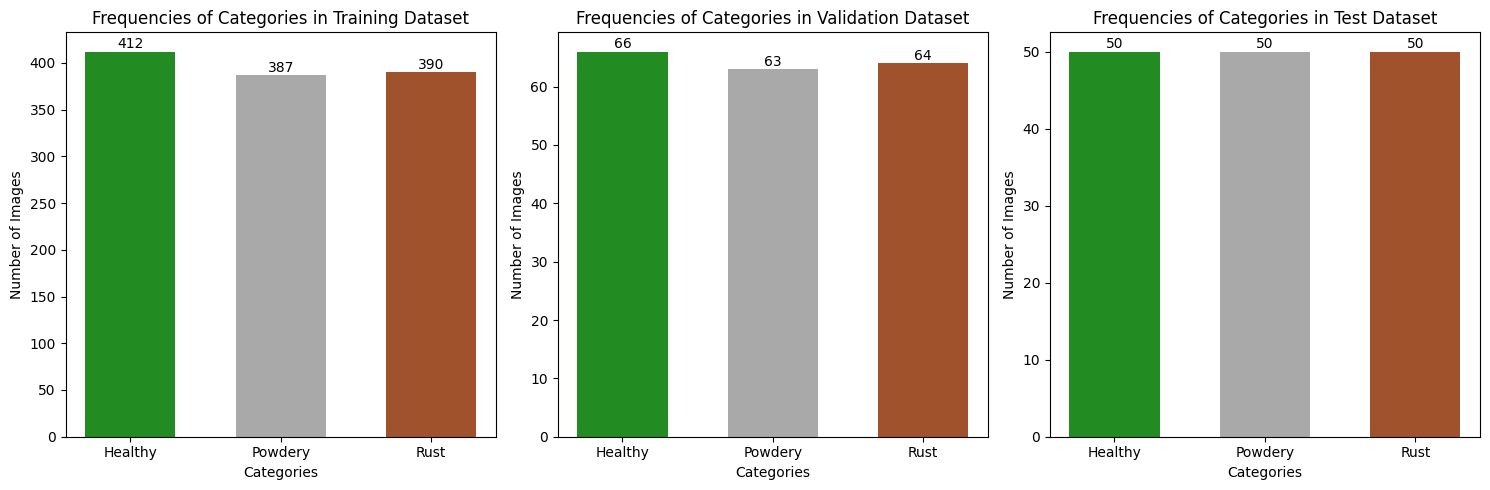

In [ ]:
plot_training_validation_test_category_frequencies(categories_list, train_directories, valid_directories, test_directories)

This dataset seems well-balanced as well as the first one, therefore we do not need to make adjustments to the classes' size

## Data Preparation

Before implementing the model, we need to preprocess the data to meet the model's requirements and facilitate its training. Since AlexNet model is design for 224x224 images, we must resize our images and transform them in tensors.
Moreover, having seen that the model applied to the unaltered images did not allow us to reach satisfactory results, we employ some transformations.

In [ ]:
train_path = '/content/Train/Train'
val_path = '/content/Validation/Validation'
test_path = '/content/Test/Test'

In the following chunks we define a first *DataLoader* for the training set, which is used to compute the mean and standard deviation.

In [ ]:
def get_dataloader_workers():
    """Use as many processes working in parallel to read the data as # CPU cores."""
    import os
    return os.cpu_count()

In [ ]:
train = torchvision.datasets.ImageFolder(train_path, transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomCrop(224),
    transforms.ToTensor()
]))
train_dl2 = DataLoader(train, 32, shuffle=True, num_workers=get_dataloader_workers(), pin_memory=True)

In [ ]:
def get_mean_std(dl):
    sum_, squared_sum, batches = 0,0,0
    for data, _ in dl:
        sum_ += torch.mean(data, dim = ([0,2,3]))
        squared_sum += torch.mean(data**2, dim = ([0,2,3]))
        batches += 1

    mean = sum_/batches
    std = (squared_sum/batches - mean**2)**0.5
    return mean,std

mean, std = get_mean_std(train_dl2)
mean, std

(tensor([0.4760, 0.5958, 0.4014]), tensor([0.1852, 0.1672, 0.1953]))

After several attemps, the best combination of transformations applied to the images in the training set is as follows:

In [ ]:
torch.manual_seed(22)

train_transform = transforms.Compose([
    transforms.Resize(224),                   # resize the input image
    transforms.RandomCrop(224),               # randomly crop the image
    transforms.RandomHorizontalFlip(),        # randomly flip the image horizontally with probability of 50%
    transforms.RandomRotation(degrees=45),    # randomly rotate the image by a maximum of 45 degrees
    transforms.ToTensor(),                    # convert the image to a PyTorch tensor
    transforms.Normalize(mean=mean, std=std), # normalize the tensor
])

In [ ]:
test_transform = transforms.Compose([transforms.Resize(224),
                                     transforms.RandomCrop(224),
                                     transforms.ToTensor()])

Due to the constrained size of this dataset, we employ data augmentation. This involves applying transformations to a duplicate of the training set and subsequently concatenating it with the original set. <br>
To simulate real-world scenarios, transformations are not applied to the validation and test sets, whereas their images are only resized and converted into tensors.

In [ ]:
torch.manual_seed(22)

train_ds = torchvision.datasets.ImageFolder(train_path, transform=test_transform)
aug_dataset = torchvision.datasets.ImageFolder(train_path, transform=train_transform)
val_dataset = torchvision.datasets.ImageFolder(val_path, transform=test_transform)
test_dataset = torchvision.datasets.ImageFolder(test_path, transform=test_transform)

In [ ]:
train_dataset = torch.utils.data.ConcatDataset([train_ds, aug_dataset])

After defining the batch size, we use the *DataLoader* class to organize the data in batches, enabling shuffling and utilizing multiple workers for efficient data loading.

In [ ]:
torch.manual_seed(22)

batch_size = 32
train_dl = DataLoader(train_dataset, batch_size, shuffle = True, num_workers = get_dataloader_workers())
val_dl = DataLoader(val_dataset, batch_size, shuffle = True, num_workers = get_dataloader_workers())
test_dl = DataLoader(test_dataset, batch_size, shuffle = True, num_workers = get_dataloader_workers())

Finally we create iterators for the training, validation and test data loaders.

In [ ]:
train_iter = iter(train_dl)
val_iter = iter(val_dl)
test_iter = iter(test_dl)

# AlexNet

In this section, we define and implement AlexNet model for the new dataset (see the other notebook for all the details).

## Model architecture

In [ ]:
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 3)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

To measure the performance of our model we use the Cross Entropy Loss Function, which is especially used when the output of a model is a probability distribution over classes.

In [ ]:
model = AlexNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

The following code executes the training phase, which proceeds through either for 20 epochs or until the stopping rule is met: if the model does not exhibit improvement in validation loss for 5 consecutive epochs, training is halted. <br>
Within each epoch, after having been trained using forward and backward passes for every batch in the training set, the model is evaluated by iterating along the validation set, to assess its performance in dealing with unseen data.
Furthermore for each epoch we compute the training and validation loss and validation accuracy.

In [ ]:
torch.manual_seed(22)
random.seed(22)
np.random.seed(22)

total_batch = len(train_dl)
val_batch = len(val_dl)

epochs = 20
tot_loss_list = []
val_loss_list = []
acc_list = []

total_epochs = 0

best_val_loss = float('inf')
patience = 5
no_improvement_count = 0

for epoch in range(epochs):
    total_epochs += 1
    total_loss = 0

    # Training
    with tqdm(enumerate(train_dl), total=len(train_dl), desc=f'Epoch {epoch + 1} Training') as progress_bar:
        for num, data in progress_bar:

            image, label = data
            image, label = image.to(device), label.to(device)
            optimizer.zero_grad()
            ypred = model.forward(image)
            loss = loss_fn(ypred, label)
            total_loss += loss

            loss.backward()
            optimizer.step()

            progress_bar.set_postfix(loss=f'{loss.item():.4f}', refresh=True)

    tot_loss_list.append((total_loss / total_batch).detach().cpu().numpy())
    print(f'Epochs: {epoch+1} Training Loss: {total_loss / total_batch}')

    with torch.no_grad():
        val_loss = 0
        total_correct = 0
        total_samples = 0

        # Validation
        with tqdm(enumerate(val_dl), total=len(val_dl), desc=f'Epoch {epoch + 1} Validation') as val_progress_bar:
            for num, data in val_progress_bar:
                val_image, val_label = data

                val_image, val_label = val_image.to(device), val_label.to(device)
                val_out = model.forward(val_image)
                v_loss = loss_fn(val_out, val_label)
                val_loss += v_loss

                _, predicted = torch.max(val_out, 1)
                total_correct += (predicted == val_label).sum().item()
                total_samples += val_label.size(0)

                val_progress_bar.set_postfix(loss=f'{v_loss.item():.4f}', refresh=True)

        accuracy_val = total_correct / total_samples
        acc_list.append(accuracy_val)

        val_loss_avg = val_loss / val_batch
        val_loss_list.append(val_loss_avg.detach().cpu().numpy())
        print(f'Epoch {epoch + 1} Validation Loss: {val_loss / val_batch}')
        print(f'Epoch {epoch + 1} Validation Accuracy: {accuracy_val}')
        print("-" * 50)

        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count >= patience:
            print(f'Early stopping at epoch {epoch + 1} as there is no improvement in validation loss.')
            break

print("Training Finished")

Epoch 1 Training: 100%|██████████| 75/75 [05:06<00:00,  4.09s/it, loss=0.9800]

Epochs: 1 Training Loss: 1.7299158573150635



Epoch 1 Validation: 100%|██████████| 7/7 [00:23<00:00,  3.37s/it, loss=1.6465]

Epoch 1 Validation Loss: 1.036989450454712
Epoch 1 Validation Accuracy: 0.5647668393782384
--------------------------------------------------



Epoch 2 Training: 100%|██████████| 75/75 [04:55<00:00,  3.94s/it, loss=0.4986]

Epochs: 2 Training Loss: 0.859307050704956



Epoch 2 Validation: 100%|██████████| 7/7 [00:24<00:00,  3.50s/it, loss=0.3527]

Epoch 2 Validation Loss: 0.852587878704071
Epoch 2 Validation Accuracy: 0.6010362694300518
--------------------------------------------------



Epoch 3 Training: 100%|██████████| 75/75 [05:03<00:00,  4.04s/it, loss=0.8468]

Epochs: 3 Training Loss: 0.7932045459747314



Epoch 3 Validation: 100%|██████████| 7/7 [00:22<00:00,  3.28s/it, loss=0.9674]

Epoch 3 Validation Loss: 0.7880886793136597
Epoch 3 Validation Accuracy: 0.6217616580310881
--------------------------------------------------



Epoch 4 Training: 100%|██████████| 75/75 [05:05<00:00,  4.07s/it, loss=0.7743]

Epochs: 4 Training Loss: 0.77115398645401



Epoch 4 Validation: 100%|██████████| 7/7 [00:22<00:00,  3.27s/it, loss=1.0276]

Epoch 4 Validation Loss: 0.8295592069625854
Epoch 4 Validation Accuracy: 0.7098445595854922
--------------------------------------------------



Epoch 5 Training: 100%|██████████| 75/75 [05:03<00:00,  4.05s/it, loss=0.7956]

Epochs: 5 Training Loss: 0.7802307605743408



Epoch 5 Validation: 100%|██████████| 7/7 [00:23<00:00,  3.33s/it, loss=1.0204]

Epoch 5 Validation Loss: 0.8206587433815002
Epoch 5 Validation Accuracy: 0.6735751295336787
--------------------------------------------------



Epoch 6 Training: 100%|██████████| 75/75 [04:58<00:00,  3.98s/it, loss=0.6619]

Epochs: 6 Training Loss: 0.7310738563537598



Epoch 6 Validation: 100%|██████████| 7/7 [00:24<00:00,  3.52s/it, loss=2.2986]

Epoch 6 Validation Loss: 0.9993515610694885
Epoch 6 Validation Accuracy: 0.7098445595854922
--------------------------------------------------



Epoch 7 Training: 100%|██████████| 75/75 [05:01<00:00,  4.02s/it, loss=0.6364]

Epochs: 7 Training Loss: 0.6866111159324646



Epoch 7 Validation: 100%|██████████| 7/7 [00:23<00:00,  3.32s/it, loss=1.1251]

Epoch 7 Validation Loss: 0.7925772070884705
Epoch 7 Validation Accuracy: 0.7668393782383419
--------------------------------------------------



Epoch 8 Training: 100%|██████████| 75/75 [05:00<00:00,  4.01s/it, loss=0.3396]

Epochs: 8 Training Loss: 0.661302387714386



Epoch 8 Validation: 100%|██████████| 7/7 [00:22<00:00,  3.28s/it, loss=1.2753]

Epoch 8 Validation Loss: 0.7721640467643738
Epoch 8 Validation Accuracy: 0.7616580310880829
--------------------------------------------------



Epoch 9 Training: 100%|██████████| 75/75 [05:04<00:00,  4.06s/it, loss=0.6459]

Epochs: 9 Training Loss: 0.5981334447860718



Epoch 9 Validation: 100%|██████████| 7/7 [00:24<00:00,  3.47s/it, loss=1.0153]

Epoch 9 Validation Loss: 0.6401117444038391
Epoch 9 Validation Accuracy: 0.7927461139896373
--------------------------------------------------



Epoch 10 Training: 100%|██████████| 75/75 [05:04<00:00,  4.06s/it, loss=1.0993]

Epochs: 10 Training Loss: 0.5681082606315613



Epoch 10 Validation: 100%|██████████| 7/7 [00:23<00:00,  3.41s/it, loss=0.0379]

Epoch 10 Validation Loss: 0.48979905247688293
Epoch 10 Validation Accuracy: 0.8341968911917098
--------------------------------------------------



Epoch 11 Training: 100%|██████████| 75/75 [04:59<00:00,  4.00s/it, loss=0.7583]

Epochs: 11 Training Loss: 0.5321758389472961



Epoch 11 Validation: 100%|██████████| 7/7 [00:22<00:00,  3.28s/it, loss=0.0094]

Epoch 11 Validation Loss: 0.4778960049152374
Epoch 11 Validation Accuracy: 0.8238341968911918
--------------------------------------------------



Epoch 12 Training: 100%|██████████| 75/75 [05:00<00:00,  4.00s/it, loss=0.3263]

Epochs: 12 Training Loss: 0.44093286991119385



Epoch 12 Validation: 100%|██████████| 7/7 [00:22<00:00,  3.25s/it, loss=0.0166]

Epoch 12 Validation Loss: 0.5211378335952759
Epoch 12 Validation Accuracy: 0.8601036269430051
--------------------------------------------------



Epoch 13 Training: 100%|██████████| 75/75 [04:57<00:00,  3.97s/it, loss=0.6226]

Epochs: 13 Training Loss: 0.44964006543159485



Epoch 13 Validation: 100%|██████████| 7/7 [00:24<00:00,  3.44s/it, loss=0.2167]

Epoch 13 Validation Loss: 0.27660298347473145
Epoch 13 Validation Accuracy: 0.9015544041450777
--------------------------------------------------



Epoch 14 Training: 100%|██████████| 75/75 [04:58<00:00,  3.97s/it, loss=0.4557]

Epochs: 14 Training Loss: 0.38553953170776367



Epoch 14 Validation: 100%|██████████| 7/7 [00:24<00:00,  3.51s/it, loss=0.0000]

Epoch 14 Validation Loss: 0.44610437750816345
Epoch 14 Validation Accuracy: 0.8601036269430051
--------------------------------------------------



Epoch 15 Training: 100%|██████████| 75/75 [04:53<00:00,  3.91s/it, loss=0.5241]

Epochs: 15 Training Loss: 0.4103688895702362



Epoch 15 Validation: 100%|██████████| 7/7 [00:24<00:00,  3.44s/it, loss=0.6375]

Epoch 15 Validation Loss: 0.6427461504936218
Epoch 15 Validation Accuracy: 0.8963730569948186
--------------------------------------------------



Epoch 16 Training: 100%|██████████| 75/75 [05:01<00:00,  4.01s/it, loss=0.4811]

Epochs: 16 Training Loss: 0.40729764103889465



Epoch 16 Validation: 100%|██████████| 7/7 [00:21<00:00,  3.13s/it, loss=0.7654]

Epoch 16 Validation Loss: 0.41100266575813293
Epoch 16 Validation Accuracy: 0.9222797927461139
--------------------------------------------------



Epoch 17 Training: 100%|██████████| 75/75 [05:01<00:00,  4.02s/it, loss=1.3007]

Epochs: 17 Training Loss: 0.3550984263420105



Epoch 17 Validation: 100%|██████████| 7/7 [00:24<00:00,  3.51s/it, loss=0.0114]

Epoch 17 Validation Loss: 0.32192593812942505
Epoch 17 Validation Accuracy: 0.8756476683937824
--------------------------------------------------



Epoch 18 Training: 100%|██████████| 75/75 [04:57<00:00,  3.97s/it, loss=0.4068]

Epochs: 18 Training Loss: 0.3921079635620117



Epoch 18 Validation: 100%|██████████| 7/7 [00:22<00:00,  3.24s/it, loss=0.5474]

Epoch 18 Validation Loss: 0.3635328412055969
Epoch 18 Validation Accuracy: 0.8963730569948186
--------------------------------------------------
Early stopping at epoch 18 as there is no improvement in validation loss.
Training Finished


Here follow two graphs representing the performance of our model along epochs.

Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

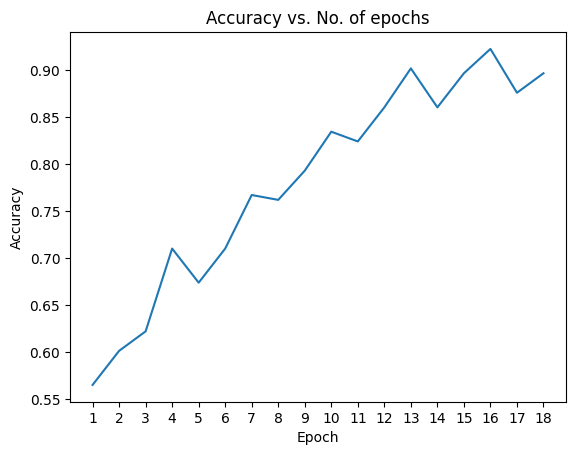

In [ ]:
plt.plot([i for i in range(1,total_epochs+1)], [j for j in acc_list])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(1, total_epochs+1))
plt.title('Accuracy vs. No. of epochs')

Text(0.5, 1.0, 'Validation and train loss vs. No. of epochs')

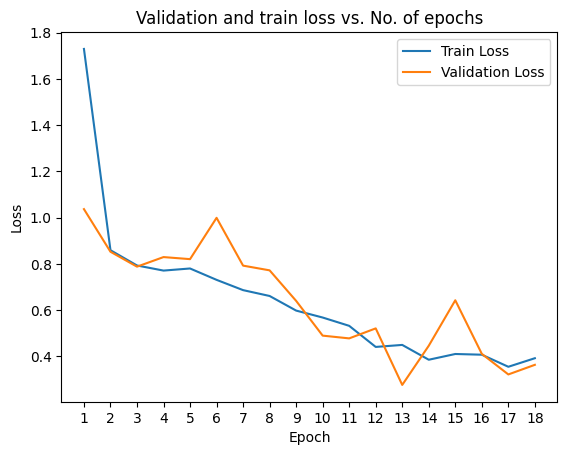

In [ ]:
plt.plot([i for i in range(1,total_epochs+1)], [j for j in tot_loss_list], label = "Train Loss")
plt.plot([i for i in range(1,total_epochs+1)], [j for j in val_loss_list], label = "Validation Loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, total_epochs+1))
plt.title('Validation and train loss vs. No. of epochs')

## Testing data

After the training phase, the model is used to classify unseen images from the test set.

In [ ]:
pred = []
Y = []
for i, (x,y) in enumerate(test_dl):
    with torch.no_grad():
        x = x.to(device)
        outputs = model(x)
    pred += [int(op.argmax()) for op in outputs]
    Y += [int(yi) for yi in y]

print(classification_report(Y, pred))

              precision    recall  f1-score   support

           0       0.89      0.82      0.85        50
           1       0.94      0.90      0.92        50
           2       0.84      0.94      0.89        50

    accuracy                           0.89       150
   macro avg       0.89      0.89      0.89       150
weighted avg       0.89      0.89      0.89       150



The model's performance can be evaluated by looking at some indicators, such as the accuracy and the F1-score, that both reach the 89%, revealing a quite strong ability in
recognizing plants' condition.

In [ ]:
categories = set()
categories.add('Healthy')
categories.add('Powdery')
categories.add('Rust')

In [ ]:
def plot_confusion_matrix(y_preds, y_test, labels):
    cm = confusion_matrix(y_test, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="BuPu", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    ax.grid(False)
    plt.show()

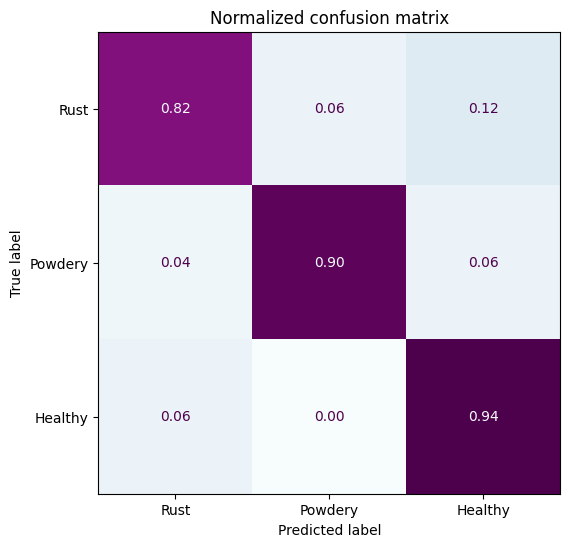

In [ ]:
plot_confusion_matrix(pred, Y, categories)

The confusion matrix shows that the model performs quite well, as previously highlighted. Unexpectedly, it encounters some minor challenges in recognizing rust diseases.

By the way of example, we illustrate the images within a batch along with their corresponding correct and predicted labels.

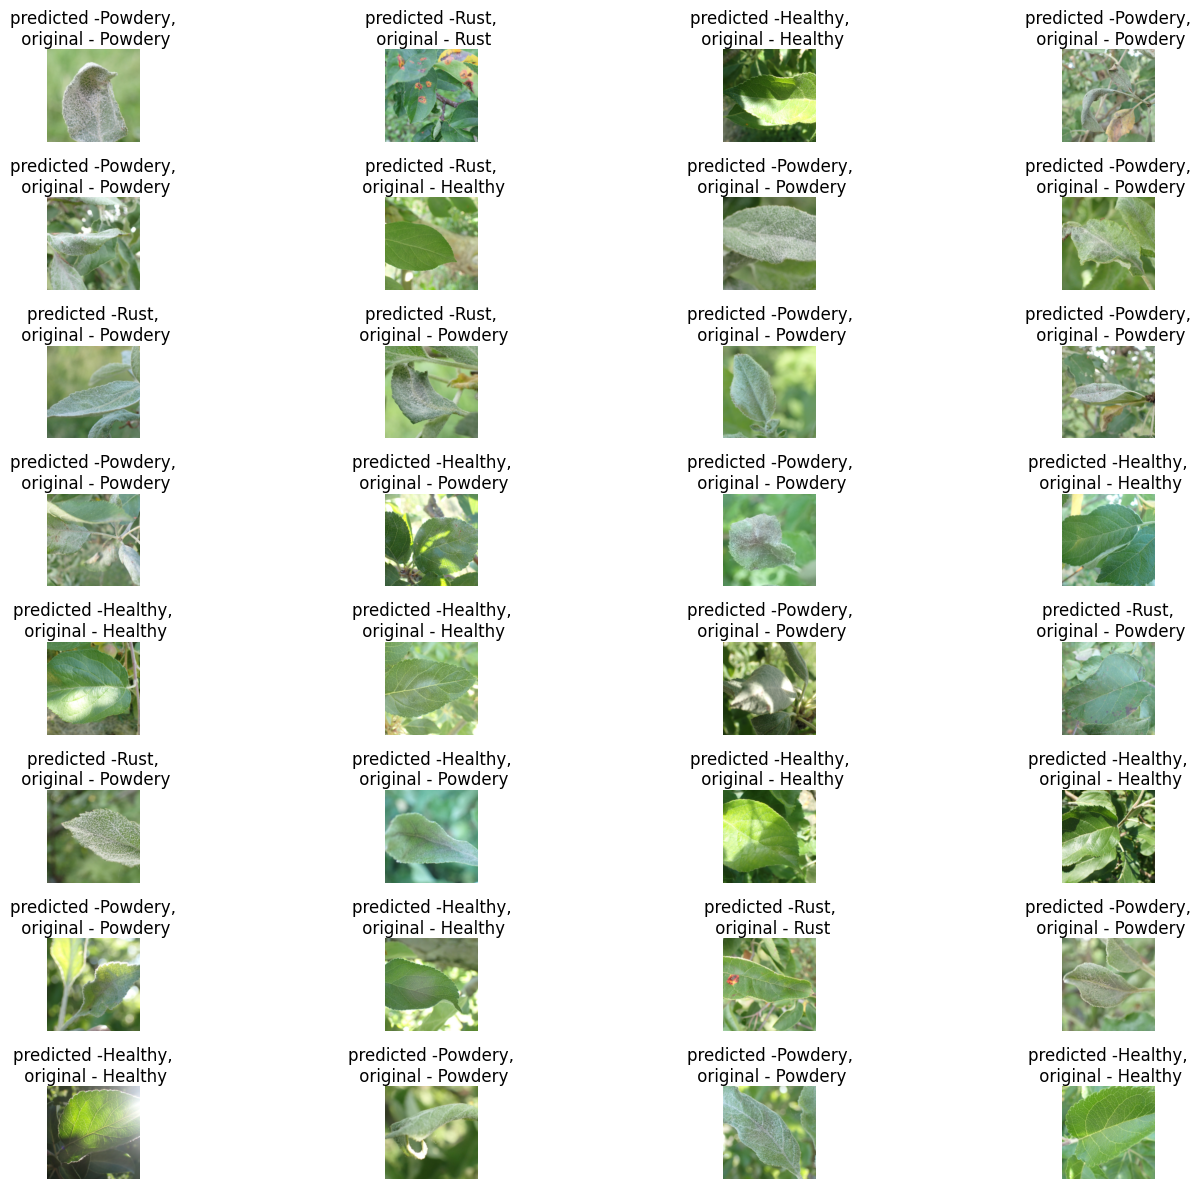

In [ ]:
samples, labels = next(test_iter)
samples = samples.to(device)
output = model(samples)

fig = plt.figure(figsize=(15, 12))
fig.tight_layout()

pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0: 'Healthy', 1: 'Powdery', 2: 'Rust'}

for num, sample in enumerate(samples):
    plt.subplot(8,4,num+1)
    plt.title(f'predicted -{ad[pred[num]]},\n original - {ad[int(labels[num])]}', loc='center', wrap=True)
    plt.axis('off')
    plt.tight_layout()
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))